In [25]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import tensorflow as tf
from torchvision import transforms
from PIL import Image
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error



In [26]:
from swin_functions_and_classes import *

class MySwinModel(nn.Module):
    def __init__(self, img_size_x, img_size_y, patch_size, embed_dim, input_resolution):
        super(MySwinModel, self).__init__()

        # Initialize the PatchEmbed module
        self.patch_embed = PatchEmbed(img_size=(img_size_x, img_size_y), patch_size=patch_size, in_chans=1, embed_dim=embed_dim)

        # Apply PatchMerging on the embedding
        self.merge_layer = PatchMerging(input_resolution=input_resolution, dim=embed_dim, norm_layer=nn.LayerNorm)

        # Create an instance of the SwinTransformerBlock class
        self.block_1 = SwinTransformerBlock(dim=embed_dim, input_resolution=input_resolution, num_heads=3, window_size=6, shift_size=0,
                                    mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                                    drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)
        
        #  shift_size is set to 3
        self.block_1_shf = SwinTransformerBlock(dim=embed_dim, input_resolution=input_resolution, num_heads=3, window_size=6, shift_size=3,
                                        mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                                        drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)

        # Define the transposed convolutional layer
        self.transposed_conv = nn.ConvTranspose2d(embed_dim, 1, kernel_size=4, stride=4, padding=0, output_padding=0)

    def forward(self, tensor_image):
        # Apply the PatchEmbed module to the tensor
        embedding = self.patch_embed(tensor_image)

        # Apply PatchMerging on the embedding
        merged_output = self.merge_layer(embedding)

        # Pass the embedding through the SwinTransformerBlock
        output = self.block_1(embedding)
        output_shf = self.block_1_shf(embedding)

        # Reshape the output to match the expected shape
        output = torch.randn((1, 16200, 48))
        output_shf = torch.randn((1, 16200, 48))    
        
        output = output.view(1, 48, 90, 180)

        # Apply the transposed convolutional layer to merge patches
        merged_image = self.transposed_conv(output)

        return merged_image

# Parameters for the model
img_size_x, img_size_y, patch_size, embed_dim, input_resolution = 360, 720, 4, 48, (90, 180)

# Create an instance of the model
my_model = MySwinModel(img_size_x, img_size_y, patch_size, embed_dim, input_resolution)


In [27]:
from torch.utils.data import Dataset, DataLoader

class ClimateDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def load_data(self):
        data = pd.read_csv(self.file_path)
        data_no_duplicates = data.drop_duplicates(subset=['Lat', 'Lon'])
        grid = data_no_duplicates.pivot(index='Lat', columns='Lon', values='Value')
        image = grid.to_numpy()

        tensor_image = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float()
        tensor_image = torch.nan_to_num(tensor_image, nan=0.0)
        tensor_image = torch.tensor(tensor_image, dtype=torch.float32)

        return tensor_image

# Specify the path to the CSV file
trainData_file_path = '../Dataset/climate_dataset/train_data.csv'
validationData_file_path = '../Dataset/climate_dataset/train_data.csv'
testData_file_path = '../Dataset/climate_dataset/test_data.csv'

# Create an instance of the custom dataset
train_dataset = ClimateDataset(trainData_file_path)
validation_dataset = ClimateDataset(validationData_file_path)
test_dataset = ClimateDataset(testData_file_path)

# Create a data loader for the dataset
batch_size = 1  # Adjust as needed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/var/folders/vv/q8xk8gh566z77g146grjnpzc0000gn/T/ipykernel_21976/1188142355.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_image = torch.tensor(tensor_image, dtype=torch.float32)
/var/folders/vv/q8xk8gh566z77g146grjnpzc0000gn/T/ipykernel_21976/1188142355.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_image = torch.tensor(tensor_image, dtype=torch.float32)
/var/folders/vv/q8xk8gh566z77g146grjnpzc0000gn/T/ipykernel_21976/1188142355.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_image = torch.tensor(ten

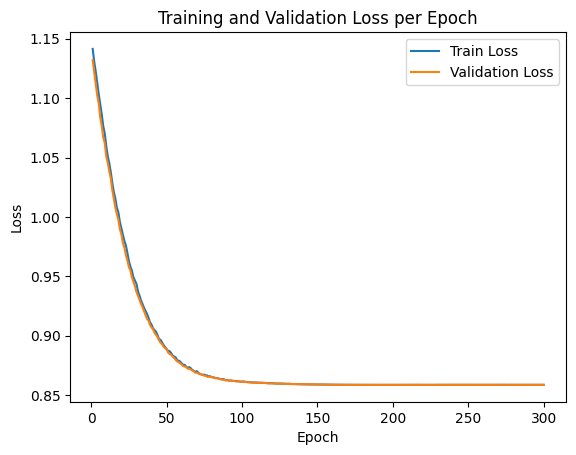

In [28]:
# Number of epochs
num_epochs = 300
best_validation_loss = float('inf')  # Set to positive infinity initially
best_model_state_dict = None

# Lists to store losses for each dataset and plot
train_losses = []
validation_losses = []

# Define the MAE loss function
mae_loss = nn.L1Loss()

# Define the optimizer
optimizer = torch.optim.Adam(params=my_model.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.3)

# Outer loop for epochs
for epoch in range(num_epochs):
    # Training loop
    # my_model.train()
    epoch_train_losses = []
    for i, image in enumerate(train_dataloader, 1):
        inputImage = image
        target = next(iter(train_dataloader))

       
        optimizer.zero_grad()
        outputImage = my_model(inputImage)

       
        # Calculate MAE loss
        train_loss = mae_loss(outputImage, target)
        train_loss.backward()
        optimizer.step()

        epoch_train_losses.append(train_loss.item())

    # Compute average training loss for the epoch
    # train_loss_avg = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(epoch_train_losses)

    # Validation loop for each epoch
    # my_model.eval()   # this line is commented out
    epoch_validation_losses = []
    with torch.no_grad():    # enable gradient calculation during training
        for i, image in enumerate(validation_dataloader, 1):
            inputImage = image
            target = next(iter(validation_dataloader))

            # print(inputImage.shape)

            outputImage = my_model(inputImage)

            # Calculate MAE loss
            validation_loss = mae_loss(outputImage, target)
            epoch_validation_losses.append(validation_loss.item())

    # Compute average validation loss for the epoch
    validation_loss_avg = sum(epoch_validation_losses) / len(epoch_validation_losses)
    validation_losses.append(validation_loss_avg)

    # Save the model if validation loss is the best so far
    if validation_loss_avg < best_validation_loss:
        best_validation_loss = validation_loss_avg
        best_model_state_dict = my_model.state_dict()

    # Print the average training and validation loss for the epoch
    # print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss_avg}, Validation Loss: {validation_loss_avg}")

    # Early stopping: Check if validation loss has stopped decreasing
    # if epoch > 0 and validation_losses[epoch] >= validation_losses[epoch - 1]:
    #     print("Early stopping! Validation loss has stopped decreasing.")
    #     break

# Plot the training and validation losses per epoch# Plot the validation and training losses per epoch
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

# Save the best model
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, 'best_model.pth')

In [29]:
#To load a saved version of the model

saved_model = MySwinModel(img_size_x, img_size_y, patch_size, embed_dim, input_resolution)
saved_model.load_state_dict(torch.load('best_model.pth'))

# Set the Model to Evaluation Mode
saved_model.eval()

MySwinModel(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 48, kernel_size=(4, 4), stride=(4, 4))
  )
  (merge_layer): PatchMerging(
    (reduction): Linear(in_features=192, out_features=96, bias=False)
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (block_1): SwinTransformerBlock(
    (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
    (attn): WindowAttention(
      (qkv): Linear(in_features=48, out_features=144, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=48, out_features=48, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
    )
    (drop_path): Identity()
    (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=48, out_features=192, bias=True)
      (act_layer): GELU(approximate='none')
      (fc2): Linear(in_features=192, out_features=48, bias=True)
      (drop): Dropout(p=0.0, inplace=Fals

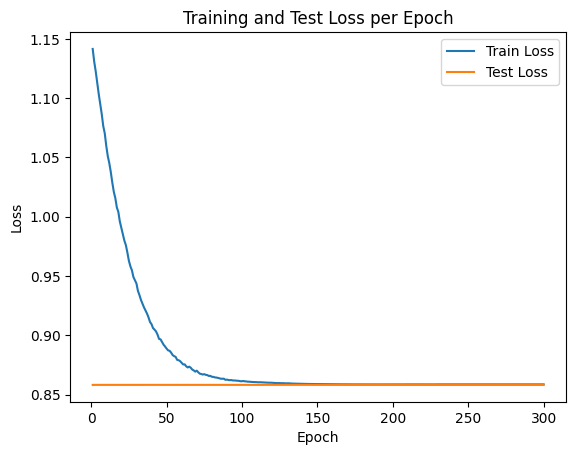

In [33]:
# Lists to store losses for each dataset and plot
test_losses = []

# Outer loop for epochs
for epoch in range(num_epochs):
    
    # Test loop
    with torch.no_grad():
        epoch_test_losses = []
        for i, image in enumerate(test_dataloader, 1):
            inputImage = image
            target = next(iter(test_dataloader))

            outputImage = saved_model(inputImage)

            # Calculate MAE loss for test dataset
            test_loss = mae_loss(outputImage, target)
            epoch_test_losses.append(test_loss.item())

    # Compute average test loss for the epoch
    test_loss_avg = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(test_loss_avg)

# Plot training and test losses per epoch
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend()
plt.show()
